## Coupled Generative Adversarial Networks

Give the noise, CoGAN can generate two images.

## Source 

- paper: https://arxiv.org/abs/1606.07536
- code: https://github.com/andrewliao11/CoGAN-tensorflow/tree/master

## Architecture

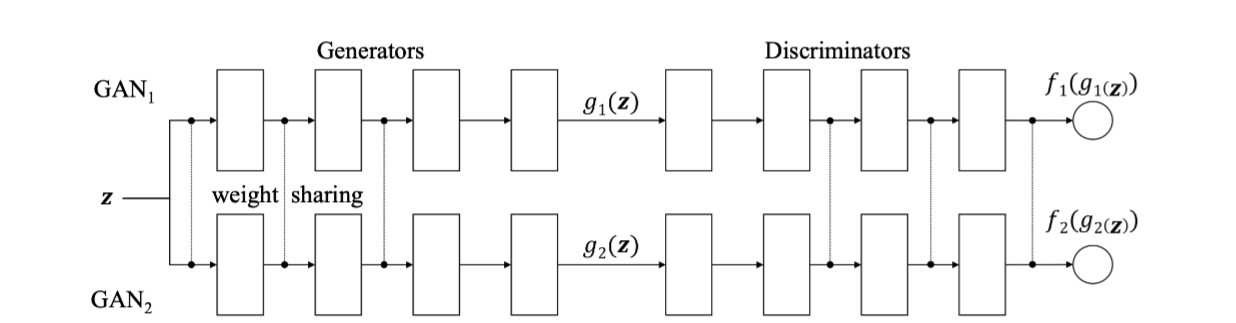

## Improt requirment library

In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, BatchNormalization, LeakyReLU, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU
from keras.layers import Reshape

## Load data

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize images to the range [0, 1] (not [-1, 1] for inversion purposes)
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Expand dimensions to match the shape (-1, 28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Invert the images (0 becomes 1, and 1 becomes 0)
invert_x_train = 1.0 - x_train
invert_x_test = 1.0 - x_test

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

### Plot training data and invert training data

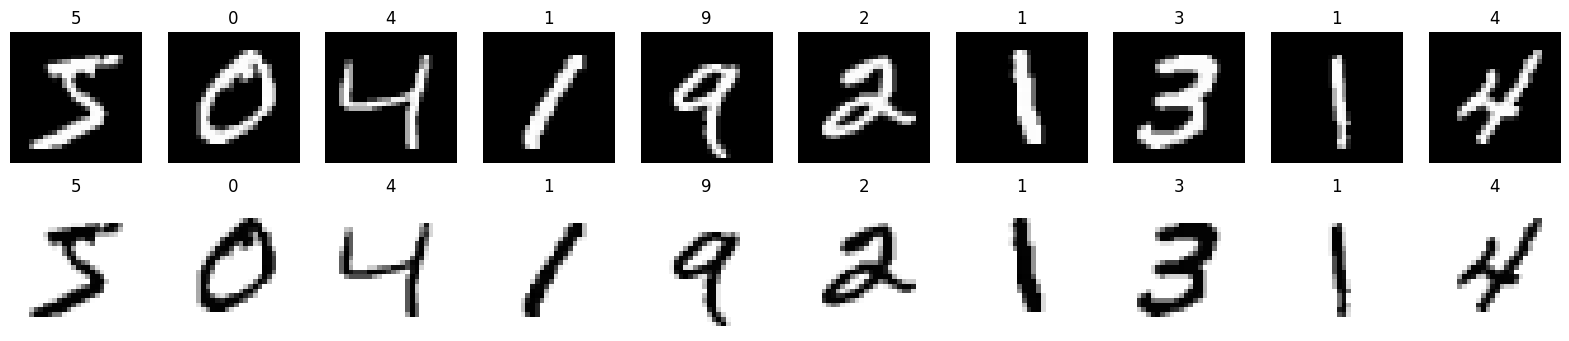

In [3]:
# Plot 10 images from x_train and their corresponding labels from y_train
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original images
    plt.subplot(2, 10, i+1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')
    
    # Inverted images
    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(invert_x_train[i].reshape(28, 28), cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')

plt.show()

## Implementation

In [16]:
def prelu(x):
    alpha = tf.Variable(tf.zeros(x.shape[-1]))
    return tf.maximum(0.0, x) + alpha * tf.minimum(0.0, x)

PReLU(x)=max(0,x)+α⋅min(0,x)

it is a relu active function with parameter term

#### Training config

In [22]:
z_dim = 100
gf_dim = 64
df_dim = 64
gfc_dim = 1024
dfc_dim = 1024
c_dim = 3

epoch = 1
learning_rate = 0.0002
beta1 = 0.5
train_size = np.inf
batch_size = 512
output_size = 64

### Generator

In [23]:
# share weights
s2 = int(output_size / 2)
s4 = int(output_size / 4)

g_h0_d = layers.Dense(gfc_dim, name='g_h0_lin')
g_h0_b = layers.BatchNormalization()

g_h1_d = layers.Dense(gf_dim * 2 * s4 * s4, name='g_h1_lin')
g_h1_b = layers.BatchNormalization()

g_h2_d = layers.Conv2DTranspose(gf_dim * 2, kernel_size=4, strides=2, padding='same', name='g_h2')
g_h2_b = layers.BatchNormalization()


# input verctor z, dimension 100 
# output batch size, output size, output size, color dimension 128*64*64*3

def build_generator(z_dim, output_size, gf_dim, gfc_dim):

    s2 = int(output_size / 2)
    s4 = int(output_size / 4)
    
    inputs = layers.Input(shape=(z_dim,))
    
    h0 = g_h0_d(inputs)
    h0 = g_h0_b(h0)
    h0 = prelu(h0)

    h1 = g_h1_d(h0)
    h1 = g_h1_b(h1)
    h1 = prelu(h1)
    h1 = layers.Reshape((s4, s4, gf_dim * 2))(h1)

    h2 = g_h2_d(h1)
    h2 = g_h2_b(h2)
    h2 = prelu(h2)

    h3 = layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same')(h2)
    output = tf.nn.sigmoid(h3)

    model = Model(inputs, output)
    return model


### Discriminator

#### Discriminator handle real image

In [24]:
# Shared weights
d_h2_d = layers.Dense(dfc_dim)
d_h2_b = layers.BatchNormalization()

d_h3_d = layers.Dense(1)

# Function to build discriminator to hadle real image.
# input batch size, output size, output size, color dimension 128*28*28*1
# output 1
def build_discriminator_real(input_shape=(28, 28, 1), df_dim=64, dfc_dim=1024):
    inputs = layers.Input(shape=input_shape)
    h0 = layers.Conv2D(df_dim, kernel_size=4, strides=2, padding='same')(inputs)
    h0 = PReLU()(h0)

    h1 = layers.Conv2D(df_dim, kernel_size=4, strides=2, padding='same')(h0)
    h1 = layers.BatchNormalization(axis=-1)(h1)  # BatchNormalization over the channels axis
    h1 = PReLU()(h1)
    h1 = layers.Flatten()(h1)

    h2 = d_h2_d(h1)
    h2 = d_h2_b(h2)  # Dense layer, axis default (last axis) is fine
    h2 = PReLU()(h2)

    h3 = d_h3_d(h2)

    model = Model(inputs, tf.nn.sigmoid(h3))
    return model


#### Discriminator handle fake image

In [25]:
# share weights
d_h2_d_f = layers.Dense(dfc_dim)
d_h2_b_f = layers.BatchNormalization()

d_h3_d_f = layers.Dense(1)


# Function to build discriminator to hadle fake image.
# input batch size, output size, output size, color dimension 128*64*64*3
# output 1

def build_discriminator_fake(input_shape, df_dim, dfc_dim):

    inputs = layers.Input(shape=input_shape)
    h0 = layers.Conv2D(df_dim, kernel_size=4, strides=2, padding='same')(inputs)
    h0 = prelu(h0)

    h1 = layers.Conv2D(df_dim, kernel_size=4, strides=2, padding='same')(h0)
    h1 = layers.BatchNormalization(axis=-1)(h1)  # BatchNormalization over the channels axis
    h1 = prelu(h1)
    h1 = layers.Flatten()(h1)

    h2 = d_h2_d_f(h1)
    h2 = d_h2_b_f(h2)  # Dense layer, axis default (last axis) is fine
    h2 = prelu(h2)

    h3 = d_h3_d_f(h2)

    model = Model(inputs, tf.nn.sigmoid(h3))
    return model

### Loss function

In [26]:
# D1_logits, D2_logits: The discriminator's output logits when fed with real data.
# D1_logits_, D2_logits_: The discriminator's output logits when fed with fake data generated by the generator.

def calculate_and_log_losses(D1_logits, D1_logits_, D2_logits, D2_logits_):
    # Caculate loss
    # By smoothing the labels to 0.9 instead of 1, the model can avoid being overconfident 
    # during training, thus improving generalization ability.
    d1_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D1_logits, labels=tf.ones_like(D1_logits) * 0.9))
    d1_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D1_logits_, labels=tf.ones_like(D1_logits_) * 0.1))
    g1_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D1_logits_, labels=tf.ones_like(D1_logits_) * 0.9))

    d2_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D2_logits, labels=tf.ones_like(D2_logits) * 0.9))
    d2_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D2_logits_, labels=tf.ones_like(D2_logits_) * 0.1))
    g2_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D2_logits_, labels=tf.ones_like(D2_logits_) * 0.9))

    # caculate total loss
    d1_loss = d1_loss_real + d1_loss_fake
    d2_loss = d2_loss_real + d2_loss_fake
    d_loss = d1_loss + d2_loss
    g_loss = g1_loss + g2_loss
        
    return d_loss, g_loss

### Training

#### Create Model

In [27]:
G1 = build_generator(z_dim, output_size, gf_dim, gfc_dim)
G2 = build_generator(z_dim, output_size, gf_dim, gfc_dim)
sampler1 = G1
sampler2 = G2

In [28]:
# real image
D1_real = build_discriminator_real(input_shape=(28, 28, 1), df_dim=64, dfc_dim=1024)
D2_real = build_discriminator_real(input_shape=(28, 28, 1), df_dim=64, dfc_dim=1024)

In [29]:
# fake image
D1 = build_discriminator_fake([output_size, output_size, c_dim], df_dim, dfc_dim)
D2 = build_discriminator_fake([output_size, output_size, c_dim], df_dim, dfc_dim)

#### Training step

In [30]:
# Define the optimizers
d_optim = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1=beta1)
g_optim = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1=beta1)

In [31]:
@tf.function
def train_step(batch_images1, batch_images2, batch_z):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images1 = G1(batch_z)
        generated_images2 = G2(batch_z)
        
        D1_logits_real = D1_real(batch_images1)
        D2_logits_real = D2_real(batch_images2)
        D1_logits_fake = D1(generated_images1)
        D2_logits_fake = D2(generated_images2)
        
        d_loss, g_loss = calculate_and_log_losses(D1_logits_real, D1_logits_fake, D2_logits_real, D2_logits_fake)
        
    gradients_of_generator = gen_tape.gradient(g_loss, G1.trainable_variables + G2.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, D1.trainable_variables + D2.trainable_variables)
    
    g_optim.apply_gradients(zip(gradients_of_generator, G1.trainable_variables + G2.trainable_variables))
    d_optim.apply_gradients(zip(gradients_of_discriminator, D1.trainable_variables + D2.trainable_variables))
    
    return d_loss, g_loss

In [32]:
# Shuffle datasets
# data_X1 is the original image
# data_X2 is the black-white image
idx = np.arange(len(y_train_one_hot))
np.random.shuffle(idx)
data_X1, data_y1 = x_train[idx], y_train_one_hot[idx]
np.random.shuffle(idx)
data_X2, data_y2 = invert_x_train[idx], y_train_one_hot[idx]

### Train1

 Using 4 discriminator, since the dimension for real images and fake images is different
 real 28*28
 fake 64*64

In [33]:
# Training loop
for e in range(epoch):
    batch_idxs = min(len(data_X1), train_size) // batch_size
    for idx in range(batch_idxs):
    
        batch_images1 = data_X1[idx*batch_size:(idx+1)*batch_size]
        batch_images2 = data_X2[idx*batch_size:(idx+1)*batch_size]
        batch_labels1 = data_y1[idx*batch_size:(idx+1)*batch_size]
        batch_labels2 = data_y2[idx*batch_size:(idx+1)*batch_size]
        batch_z = np.random.normal(size=[batch_size, z_dim]).astype(np.float32)

        # Update D network
        d_loss, g_loss = train_step(batch_images1, batch_images2, batch_z)
        
        # Update G network twice to ensure d_loss does not go to zero
#         _ = train_step(batch_images1, batch_images2, batch_z)
#         _ = train_step(batch_images1, batch_images2, batch_z)

        print(f"Epoch: [{e}/{epoch}] [{idx}/{batch_idxs}] d_loss: {d_loss.numpy()}, g_loss: {g_loss.numpy()}")


Epoch: [0/1] [0/117] d_loss: 2.8991875648498535, g_loss: 1.0488301515579224
Epoch: [0/1] [1/117] d_loss: 2.4429030418395996, g_loss: 1.381974220275879
Epoch: [0/1] [2/117] d_loss: 2.4387364387512207, g_loss: 1.385972023010254
Epoch: [0/1] [3/117] d_loss: 2.4384796619415283, g_loss: 1.3861867189407349
Epoch: [0/1] [4/117] d_loss: 2.438807249069214, g_loss: 1.3862266540527344
Epoch: [0/1] [5/117] d_loss: 2.4384355545043945, g_loss: 1.3862407207489014
Epoch: [0/1] [6/117] d_loss: 2.4386115074157715, g_loss: 1.3862473964691162
Epoch: [0/1] [7/117] d_loss: 2.438485860824585, g_loss: 1.3862520456314087
Epoch: [0/1] [8/117] d_loss: 2.438419818878174, g_loss: 1.3862553834915161
Epoch: [0/1] [9/117] d_loss: 2.4382736682891846, g_loss: 1.3862587213516235
Epoch: [0/1] [10/117] d_loss: 2.4386563301086426, g_loss: 1.386260747909546
Epoch: [0/1] [11/117] d_loss: 2.4385108947753906, g_loss: 1.386263370513916
Epoch: [0/1] [12/117] d_loss: 2.438511848449707, g_loss: 1.3862652778625488
Epoch: [0/1] [13/

Epoch: [0/1] [108/117] d_loss: 2.438493013381958, g_loss: 1.3862926959991455
Epoch: [0/1] [109/117] d_loss: 2.438481092453003, g_loss: 1.386292815208435
Epoch: [0/1] [110/117] d_loss: 2.4384405612945557, g_loss: 1.3862929344177246
Epoch: [0/1] [111/117] d_loss: 2.4384796619415283, g_loss: 1.3862929344177246
Epoch: [0/1] [112/117] d_loss: 2.4383816719055176, g_loss: 1.3862929344177246
Epoch: [0/1] [113/117] d_loss: 2.438491106033325, g_loss: 1.3862929344177246
Epoch: [0/1] [114/117] d_loss: 2.4384605884552, g_loss: 1.3862929344177246
Epoch: [0/1] [115/117] d_loss: 2.4384665489196777, g_loss: 1.3862929344177246
Epoch: [0/1] [116/117] d_loss: 2.4384312629699707, g_loss: 1.3862929344177246


In [34]:
sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

In [35]:
g1_image = G1(sample_z)
g2_image = G2(sample_z)

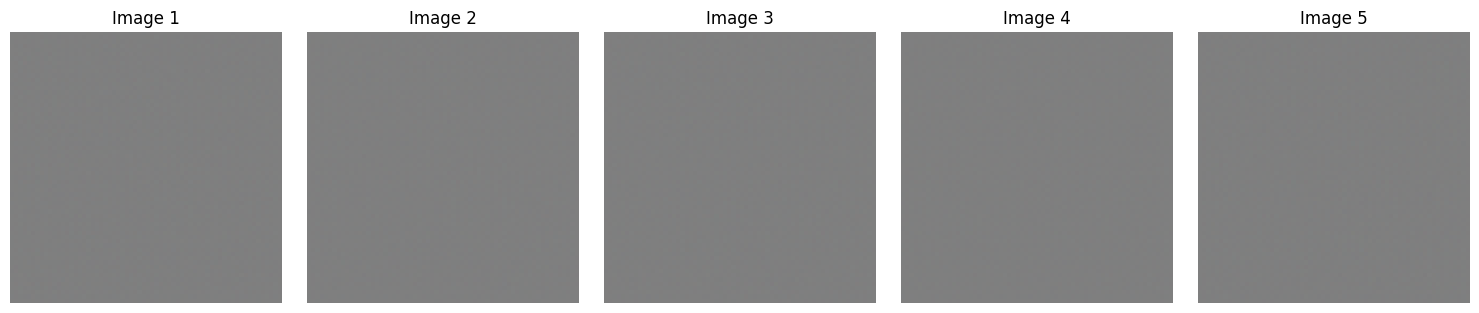

In [67]:
# Create a figure to plot the images
plt.figure(figsize=(15, 6))
num_images = 5

# Loop through the number of images
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(g1_image[i])
    plt.axis('off')
    plt.title(f'Image {i + 1}')

# Show the plot
plt.tight_layout()
plt.show()

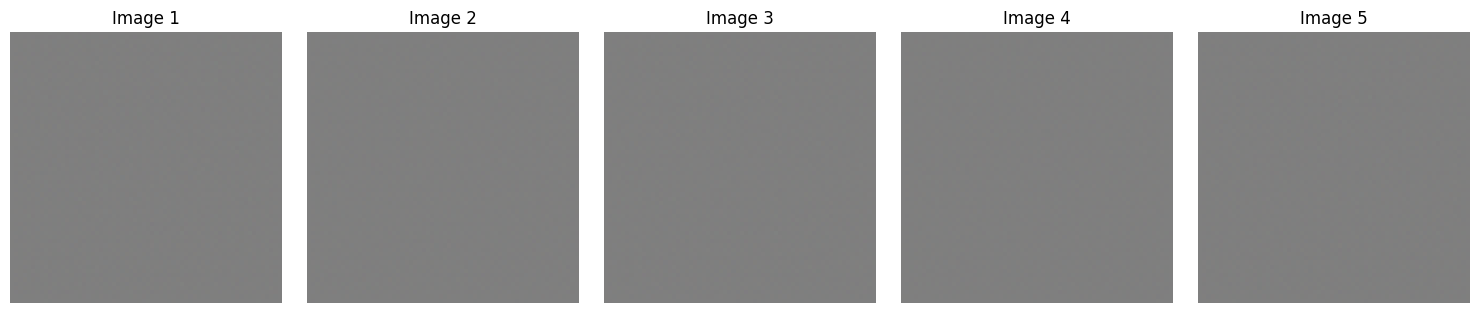

In [68]:
# Create a figure to plot the images
plt.figure(figsize=(15, 6))
num_images = 5

# Loop through the number of images
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(g2_image[i])
    plt.axis('off')
    plt.title(f'Image {i + 1}')

# Show the plot
plt.tight_layout()
plt.show()

### Train2

Using 2 discriminator by resize the real image to 64*64.

In [44]:
G11 = build_generator(z_dim, output_size, gf_dim, gfc_dim)
G22 = build_generator(z_dim, output_size, gf_dim, gfc_dim)

In [45]:
# fake image
D11 = build_discriminator_fake([output_size, output_size, c_dim], df_dim, dfc_dim)
D22 = build_discriminator_fake([output_size, output_size, c_dim], df_dim, dfc_dim)

In [55]:
def resize_and_convert_image(input_image):
    """
    Resizes a 28x28x1 image to 64x64x3.

    Parameters:
    input_image (tf.Tensor): Input image of shape (28, 28, 1).

    Returns:
    tf.Tensor: Output image of shape (64, 64, 3).
    """
    # Resize the image to 64x64
    resized_image = tf.image.resize(input_image, [64, 64])
    
    # Convert grayscale image to RGB
    output_image = tf.image.grayscale_to_rgb(resized_image)
    
    return output_image

In [58]:
# Define the optimizers
d2_optim = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1=beta1)
g2_optim = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1=beta1)

In [59]:
@tf.function
def train_step2(batch_images1, batch_images2, batch_z):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images1 = G11(batch_z)
        generated_images2 = G22(batch_z)
        
        batch_images1 = resize_and_convert_image(batch_images1)
        batch_images2 = resize_and_convert_image(batch_images2)
        
        D11_logits_real = D11(batch_images1)
        D22_logits_real = D22(batch_images2)
        D11_logits_fake = D11(generated_images1)
        D22_logits_fake = D22(generated_images2)
        
        d_loss, g_loss = calculate_and_log_losses(D11_logits_real, D11_logits_fake, D22_logits_real, D22_logits_fake)
        
    gradients_of_generator = gen_tape.gradient(g_loss, G11.trainable_variables + G22.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, D11.trainable_variables + D22.trainable_variables)
    
    g2_optim.apply_gradients(zip(gradients_of_generator, G11.trainable_variables + G22.trainable_variables))
    d2_optim.apply_gradients(zip(gradients_of_discriminator, D11.trainable_variables + D22.trainable_variables))
    
    return d_loss, g_loss

In [60]:
# Training loop
for e in range(epoch):
    batch_idxs = min(len(data_X1), train_size) // batch_size
    for idx in range(batch_idxs):
    
        batch_images1 = data_X1[idx*batch_size:(idx+1)*batch_size]
        batch_images2 = data_X2[idx*batch_size:(idx+1)*batch_size]
        batch_labels1 = data_y1[idx*batch_size:(idx+1)*batch_size]
        batch_labels2 = data_y2[idx*batch_size:(idx+1)*batch_size]
        batch_z = np.random.normal(size=[batch_size, z_dim]).astype(np.float32)

        # Update D network
        d_loss, g_loss = train_step2(batch_images1, batch_images2, batch_z)
        
        # Update G network twice to ensure d_loss does not go to zero
#         _ = train_step(batch_images1, batch_images2, batch_z)
#         _ = train_step(batch_images1, batch_images2, batch_z)

        print(f"Epoch: [{e}/{epoch}] [{idx}/{batch_idxs}] d_loss: {d_loss.numpy()}, g_loss: {g_loss.numpy()}")


Epoch: [0/1] [0/117] d_loss: 2.7426600456237793, g_loss: 1.385836124420166
Epoch: [0/1] [1/117] d_loss: 2.6367111206054688, g_loss: 1.376588225364685
Epoch: [0/1] [2/117] d_loss: 2.5551888942718506, g_loss: 1.3560316562652588
Epoch: [0/1] [3/117] d_loss: 2.5158326625823975, g_loss: 1.3861632347106934
Epoch: [0/1] [4/117] d_loss: 2.502548933029175, g_loss: 1.3862570524215698
Epoch: [0/1] [5/117] d_loss: 2.4964966773986816, g_loss: 1.3862240314483643
Epoch: [0/1] [6/117] d_loss: 2.4947524070739746, g_loss: 1.386159896850586
Epoch: [0/1] [7/117] d_loss: 2.4940550327301025, g_loss: 1.3861415386199951
Epoch: [0/1] [8/117] d_loss: 2.493783473968506, g_loss: 1.3861777782440186
Epoch: [0/1] [9/117] d_loss: 2.493471384048462, g_loss: 1.3862111568450928
Epoch: [0/1] [10/117] d_loss: 2.4933314323425293, g_loss: 1.3862310647964478
Epoch: [0/1] [11/117] d_loss: 2.4932756423950195, g_loss: 1.386243462562561
Epoch: [0/1] [12/117] d_loss: 2.4932942390441895, g_loss: 1.3862504959106445
Epoch: [0/1] [13

Epoch: [0/1] [108/117] d_loss: 2.492711305618286, g_loss: 1.3862929344177246
Epoch: [0/1] [109/117] d_loss: 2.4927122592926025, g_loss: 1.3862929344177246
Epoch: [0/1] [110/117] d_loss: 2.492709159851074, g_loss: 1.3862930536270142
Epoch: [0/1] [111/117] d_loss: 2.4927101135253906, g_loss: 1.3862930536270142
Epoch: [0/1] [112/117] d_loss: 2.4927103519439697, g_loss: 1.3862930536270142
Epoch: [0/1] [113/117] d_loss: 2.492708444595337, g_loss: 1.3862931728363037
Epoch: [0/1] [114/117] d_loss: 2.492710590362549, g_loss: 1.3862934112548828
Epoch: [0/1] [115/117] d_loss: 2.492709159851074, g_loss: 1.3862934112548828
Epoch: [0/1] [116/117] d_loss: 2.492708206176758, g_loss: 1.3862934112548828


In [61]:
sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

In [69]:
sample_z = np.random.normal(size=[batch_size, z_dim]).astype(np.float32)

In [70]:

g11_images = G11(sample_z)
g22_images = G22(sample_z)

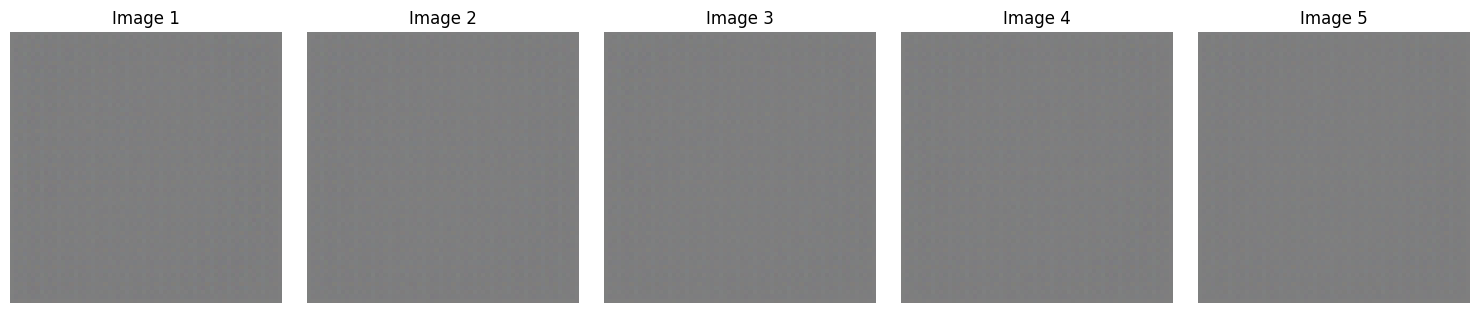

In [71]:
# Create a figure to plot the images
plt.figure(figsize=(15, 6))
num_images = 5

# Loop through the number of images
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(g11_images[i])
    plt.axis('off')
    plt.title(f'Image {i + 1}')

# Show the plot
plt.tight_layout()
plt.show()

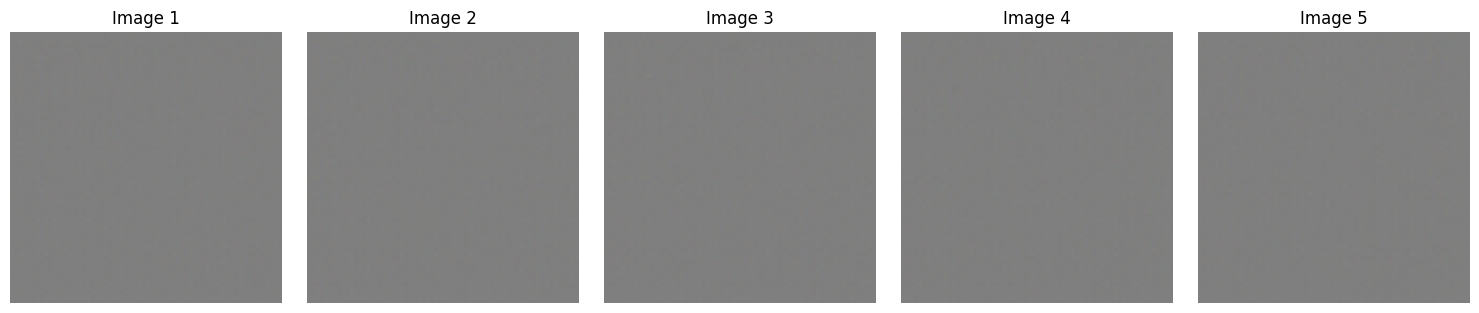

In [66]:
# Create a figure to plot the images
plt.figure(figsize=(15, 6))
num_images = 5

# Loop through the number of images
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(g22_images[i])
    plt.axis('off')
    plt.title(f'Image {i + 1}')

# Show the plot
plt.tight_layout()
plt.show()